# Forecasting Inflation Rate of Poland Using ARIMA Model in Python

Author: **Marcin Sikorski**<br>
Date: December, 2021

Recently inflation is a popular topic in Poland and is highest since 2001. Experts presume inflation in Poland should continue to rise, and by the end of 2021 it will be close to 8%. In this notebook we will develop a forecasting model for time series using Python.

**Understanding inflation**<br>
Inflation is a general progressive increase in prices of goods and services, or decline in the value of money. It is one of the basic measures describing the economy of a given country. The most easy way to pull back inflation is to raise interest rates. When interest rates are low, individuals and businesses tend to demand more loans. 

**What causes inflation in Poland?**<br>
Economies in most regions of the world are struggling with increased inflation, which is due to: rising fuel prices, disruptions in supply chains and a strong postpandemic recovery. The strong price pressure in Poland is also due to the continued high pace of fuel prices and further increases in food prices. Energy prices were 7.2% up, and should accelerate further due to the already announced natural gas price hike, starting from October (sources: [Business Insider][1], [ING][2]).

**Dataset description**<br>
The dataset for this project originates from Statistics Poland website [GUS][3] [Accessed 6th December 2021]. Dataset contains inflation rates (percentage change per month) from January 1997 to November 2021 in tabular form.

[1]:https://businessinsider.com.pl/finanse/inflacja-we-wrzesniu-2021-r-byla-najwyzsza-od-20-lat/t845sbv 'Business Insider'
[2]:https://think.ing.com/snaps/inflation-in-poland-continues-unabated-may-near-7-in-december 'ING'
[3]:https://stat.gov.pl/en/topics/prices-trade/price-indices/harmonized-indices-of-consumer-prices-hicp,15,1.html 'Statistics Poland'

### 1. Loading and Processing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data from xlsx file
dataset = pd.read_excel('poland_inflation_ratings.xlsx')
dataset.tail()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
20,2017,1.4,1.9,1.8,1.8,1.5,1.3,1.4,1.4,1.6,1.6,2.0,1.7
21,2018,1.6,0.7,0.7,0.9,1.2,1.4,1.4,1.4,1.5,1.5,1.1,0.9
22,2019,0.6,1.3,1.7,2.1,2.2,2.3,2.5,2.6,2.4,2.3,2.4,3.0
23,2020,3.8,4.1,3.9,2.9,3.4,3.8,3.7,3.7,3.8,3.8,3.7,3.4
24,2021,3.6,3.6,4.4,5.1,4.6,4.1,4.7,5.0,5.6,6.4,7.7,NaN


In [3]:
# unpivot from wide to long format
dataset = dataset.melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.head()

,Year,Month,Rate
0,1997,1,17.7
1,1998,1,13.6
2,1999,1,6.8
3,2000,1,10.1
4,2001,1,7.4


In [4]:
# add new date column and assign last day of month
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)

# order ascending data values 
dataset = dataset.sort_values(by=['Date'])
dataset.head()

,Year,Month,Rate,Date
0,1997,1,17.7,1997-01-31
25,1997,2,17.4,1997-02-28
50,1997,3,16.5,1997-03-31
75,1997,4,15.3,1997-04-30
100,1997,5,14.4,1997-05-31


In [5]:
# select needed columns
df = dataset[['Date', 'Rate']]

# set date column as index
df.set_index('Date', inplace=True)

# drop NaN rows
df.dropna(subset=['Rate'], inplace=True)
df.tail()

,Rate
Date,
2021-07-31,4.7
2021-08-31,5.0
2021-09-30,5.6
2021-10-31,6.4
2021-11-30,7.7


In [6]:
# summary of final DataFrame
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,299.0,3.751171,3.81678,-1.3,1.2,3.0,4.4,17.7


### 2. Visualizing Time Series

Our dataset is ready for further actions. Lets plot some figures.

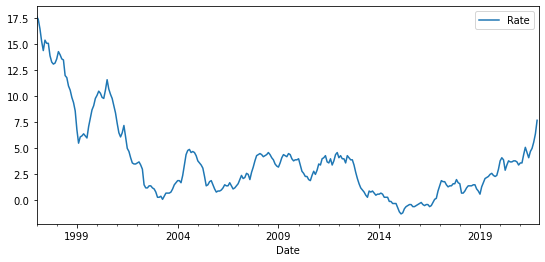

In [7]:
# time series of inflation percentage
dataset.plot(x='Date', y='Rate', figsize=(9,4))

<function matplotlib.pyplot.show(*args, **kw)>

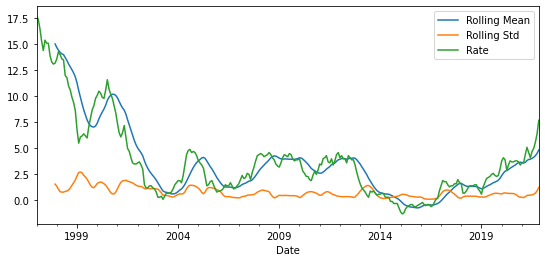

In [8]:
# more time series of inflation percentage
time_series = df['Rate']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(9,4))
plt.legend()
plt.show()

From this plot we can see Polish inflation is a complex measure. The standard deviation is not flattened and the behaviour seems to be quite dynamic in time.

To understand more about our time series and get more insights for future predicting, we will plot it's decomposition. These components are defined as follows:
* observed: the actual value in the series;
* trend: the increasing or decreasing value in the series;
* seasonality: the repeating short-term cycle or pattern in the series;
* residual/noise: the random variation in the series.

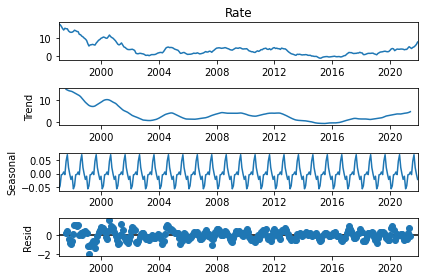

In [9]:
# plot decomposition components
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

### 3. Introduction to ARIMA Model

ARIMA (aka Box-Jenkins) is an acronym that is short for Auto Regressive Integrated Moving Average. It is a class of model that that captures a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any non-seasonal time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. Seasonal changes or patterns require extending this model into Seasonal ARIMA (SARIMA) by adding seasonal terms. Since inflation in Poland is definitely non-seasonal, this type of model should fit great.

To build an accurate statistical model it is crucial to know its parameters <code>(p, d, q)</code> which are integer values.

The parameters of the ARIMA model are defined as follows:<br>
* <code>p</code>: number of lag observations included in the model, also called the lag order (AR term);
* <code>d</code>: number of times that the raw observations are differenced, also called the degree of differencing (I term);
* <code>q</code>: number of differencing required to make the time series stationary (MA term).

We need to find the value of each term, but before that we must check if our dataset is stationary.

### 4. Identifying if the Data is Stationary

To check if the inflation series is stationary, we will implement the Augmented Dickey Fuller (ADF) test. To identify the nature of data, we will be using the null hypothesis.

The null hypothesis ($H_0$) of the ADF test is that the data is non stationary. If the <code>P-value</code> of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the series is indeed stationary.

So, in other words, if <code>P-value</code> is greater the 0.05 (data is non stationary) we will need to find the order of differencing. Otherwise, we can assign it is equal 0.

In [10]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['Rate'])

1. ADF:  -3.841632389326831
2. P-value:  0.0025089581803275397
3. Num of Lags:  13
4. Num of Observations:  285
5. Critial Values:
	 1% :  -3.4535050041524245
	 5% :  -2.8717352599720294
	 10% :  -2.5722024776854417

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


<code>P-value</code> is below 0.05 which means our data series is stationary. We can skip finding <code>d</code> term but for this purpose we will show methodology of determining it in the next step.

### 5. Differencing - Determining *d* Order

Using <code>pmdarima</code> package we can easily find value of <code>d</code> term with different tests. Since our time series is stationary, we will still accept <code>d</code> term to be 0 because there is no need of calculating it.

In [11]:
# finding differencing value
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Rate'], test='adf'))
print(ndiffs(df['Rate'], test='kpss'))
print(ndiffs(df['Rate'], test='pp'))

1
2
1


### 6. Autocorrelation (ACF) and Partial Autocorrelation (PACF) - Determining *p* and *q* Order

Autocorrelation it is a statistic describing the extent to which a given term of the series depends on the previous terms in the time series (with a constant time shift). Partial autocorrelation expresses the correlation between observations made at two points in time while accounting for any influence from other observations.

By plotting ACF and PACF we are able to determine <code>p</code> and <code>q</code>. We can use ACF to determine the optimal number of MA terms and PACF to determine the optimal number of terms to use in the AR model.

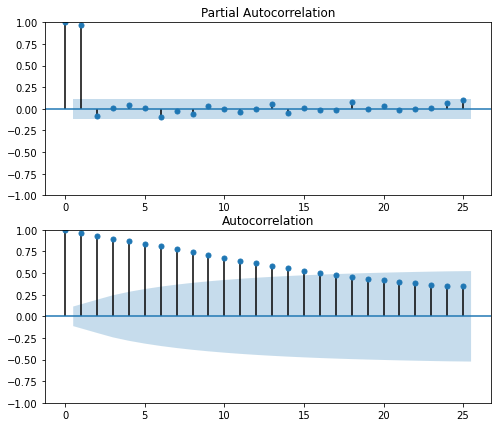

In [12]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

From PACF graph we can determine <code>p</code> is equal 2. The theoretical PACF tapers toward 0 in some manner and partial autocorrelations are equal to 0 beyond that point. The number of non zero partial autocorrelations gives the order of the AR term. Put another way, only the vertical spikes that exceed the horizontal lines are considered significant. We can observe this behaviour on lag 2.

From ACF graph we can determine <code>q</code> order. The autocorrelations are significant for a large number of lags. Perhaps the autocorrelations at lags 2 and above are merely due to the propagation of the autocorrelation at lag 1, which is confirmed by the PACF plot. We will accept <code>q</code> as 1.

### 7. Auto ARIMA Function to Find Best Order for Model

Auto ARIMA is another function which can help us find the best fit and determine our three parameters in an automatic way. It uses a stepwise approach to search multiple combinations of <code>(p, d, q)</code> terms and chooses the best model that has the least AIC. For this task we will again use <code>pmdarima</code> module. We will just demonstrate it and not implement its results for final model.

In [13]:
# auto ARIMA function
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=332.745, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=420.078, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=399.241, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=361.354, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=330.280, Time=0.23 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=333.189, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=328.746, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=330.214, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=384.237, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.852 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -161.373
Date:                Thu, 09 Dec 2021   AIC                            328.746
Time:                        13:24:02   BIC                            339.827
Sample:                             0   HQIC                           333.182
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4007      0.049      8.171      0.000       0.305       0.497
ma.L1         -0.9786      0.020    -47.910      0.000      -1.019      -0.939
sigma2         0.1722      0.011     16.284      0.000       0.151       0.193
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                44.21
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The function suggests (1,2,1) to be the best order.

### 8. Developing the ARIMA Model

Now, that we determined and know the values of our order, we can finally implement it to ARIMA model.

In [14]:
# p=2, d=0, q=1
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(2,0,1), freq='M')
model_fit = model.fit()
model_fit.summary()

c:\python\python383\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  299
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -163.645
Date:                Thu, 09 Dec 2021   AIC                            337.290
Time:                        13:24:05   BIC                            355.792
Sample:                    01-31-1997   HQIC                           344.695
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5754      3.770      2.275      0.023       1.186      15.964
ar.L1          1.3885      0.102     13.585      0.000       1.188       1.589
ar.L2         -0.3924      0.101     -3.868      0.000      -0.591      -0.194
ma.L1          0.0475      0.126      0.379      0.705      -0.198       0.294
sigma2         0.1717      0.010     16.368      0.000       0.151       0.192
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                39.20
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# predict values
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

In [16]:
# display last rows
pred.tail()

2021-07-31    3.907970
2021-08-31    4.988289
2021-09-30    5.132289
2021-10-31    5.869340
2021-11-30    6.747679
Freq: M, Name: predicted_mean, dtype: float64

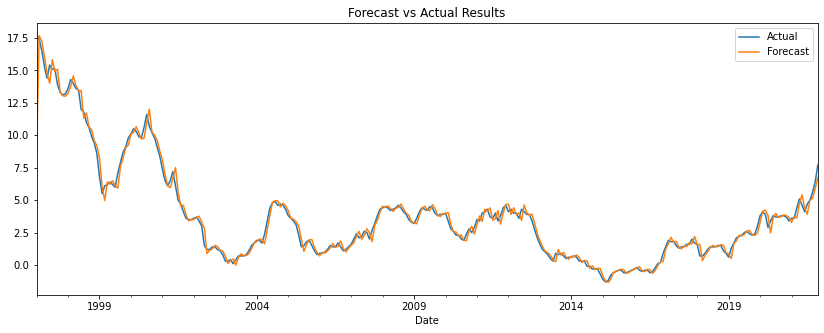

In [17]:
# plot results
df['Rate'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

### 9. Accuracy Metrics and Measure Performance of Fitted Model

We will plot diagnostics and calculate some accuracy metrics to judge the performance of our model.

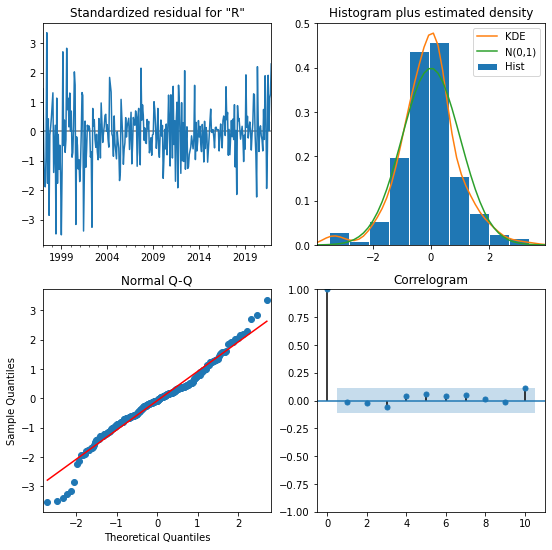

In [18]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

**Top left plot:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top right plot:** The density plot suggest normal distribution with mean around zero.

**Bottom left plot:** All the markers should lay perfectly on the red line. Any significant deviations would imply the distribution is skewed.

**Bottom right plot:** The correlogram shows the residual errors are not autocorrelated. Any autocorrelation would suggest that there is some pattern in the residual errors which are not explained in the model.

Overall, these figures do not signal any anomalies and the fit is good.

In [19]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(pred, df['Rate'], squared=False)
rmse

0.6700547860928148

In [20]:
# mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred, df['Rate'])
mae

0.3308269031490373

In [21]:
# mean absolute percentage error
mape = np.mean(np.abs(df['Rate'] - pred) / df['Rate']) * 100
mape

9.723911074349086

In [22]:
# correlation
corr = np.corrcoef(pred, df['Rate'])[0,1]
corr

0.9844489551560021

### 10. Extrapolating Future Inflation Data

Now, the final part. We will forecast future inflation rates for the coming months and plot results.

In [23]:
# predict values
forecast = model_fit.predict(start=0, end=len(df) + 4, typ='levels', dynamic=False)

In [24]:
# display forecasted values
forecast.tail(5)

2021-12-31    8.258834
2022-01-31    8.479362
2022-02-28    8.566273
2022-03-31    8.600413
2022-04-30    8.613712
Freq: M, Name: predicted_mean, dtype: float64

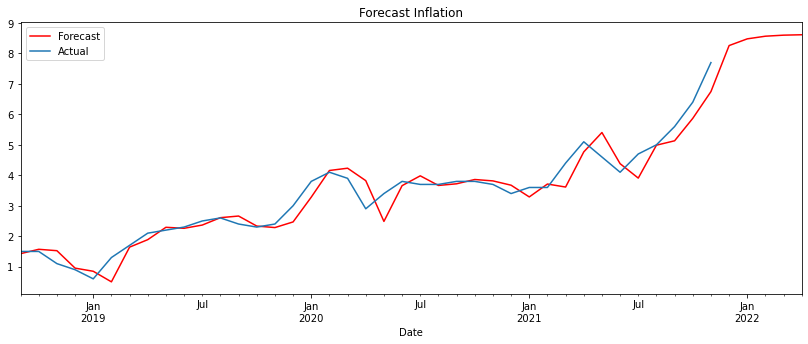

In [25]:
# final plot
forecast.iloc[260:].plot(legend=True, label='Forecast', figsize=(14,5), color='red')
df['Rate'].iloc[260:].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()

### Conclusions

We forecasted inflation rates by developing a machine learning algorithm. As accepted, inflation in Poland will continue to increase and by the end of December 2021, it should reach 8.3%, and 8.5% in January 2022. We should still expect higher prices of goods and services over the next months.

Using ARIMA model, we can forecast and analyze a time series using the series past values. We need to keep in mind ARIMA is indented for non seasonal time series. An effective and accurate ARIMA model crucially depends on its orders <code>(p, d, q)</code>. Each term requires its manual identifying. Examining ACF and PACF plots to determine order values is sometimes tricky. We also demonstrated an automatic function, with a stepwise approach to find the best fit.

Time series predicting is really useful for future decisions. It is an important part of data analysis. ARIMA model is easy to understand, matches most time series, and accurately forecasts future values. Although, it requires lots of prior knowledge to use it successfully.